# INTRO

This notebook is following 
https://www.kaggle.com/code/dimitriosroussis/electricity-price-forecasting-with-dnns-eda

Goal is to predict the _next hour_ electricity price. 
- EDA
- Feature engineering 

Modelling is done via several achitectures


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt

%matplotlib inline

2023-10-10 16:03:10.471463: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))


# Datasets
Here we have two .csv files 
- weather...csv _Hourly_ weather conditions
- energy...csv _Hourly_ energy generation, load, and price (energy generation is in MWh)

Weather data is for __5 Big cities__ that cover all the spain territory. 

In [3]:
df_weather = pd.read_csv("./weather_features.csv", parse_dates=["dt_iso"])
df_energy = pd.read_csv("./energy_dataset.csv", parse_dates=["time"])

### EDA on energy dataset

- Examine zeroes and nans 
- Remove columns that are fully 0 or nan
- Find where Nans are with visualization
- Use interpolation to fill nans if there is not much missing (do not drop rows)

In [4]:
df_energy.head()

time  generation biomass  \
0  2015-01-01 00:00:00+01:00               447.0   
1  2015-01-01 01:00:00+01:00               449.0   
2  2015-01-01 02:00:00+01:00               448.0   
3  2015-01-01 03:00:00+01:00               438.0   
4  2015-01-01 04:00:00+01:00               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                       4755.0                  158.0   
2                 4857.0                       4581.0                  157.0   
3                 4314.0                       4131.0                  160.0   
4                 4130.0                       3840.0                  156.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                     0.0                    0.0   
1                          0.0                     0.0                    0.0   
2                          0.0                     0.0                    0.0   
3                          0.0                     0.0                    0.0   
4                          0.0                     0.0                    0.0   

   ...  generation waste  generation wind offshore  generation wind onshore  \
0  ...             196.0                       0.0                   6378.0   
1  ...             195.0                       0.0                   5890.0   
2  ...             196.0                       0.0                   5461.0   
3  ...             191.0                       0.0                   5238.0   
4  ...             189.0                       0.0                   4935.0   

   forecast solar day ahead  forecast wind offshore eday ahead  \
0                      17.0                                NaN   
1                      16.0                                NaN   
2                       8.0                                NaN   
3                       2.0                                NaN   
4                       9.0                                NaN   

   forecast wind onshore day ahead  total load forecast  total load actual  \
0                           6436.0              26118.0            25385.0   
1                           5856.0              24934.0            24382.0   
2                           5454.0              23515.0            22734.0   
3                           5151.0              22642.0            21286.0   
4                           4861.0              21785.0            20264.0   

   price day ahead  price actual  
0            50.10         65.41  
1            48.10         64.92  
2            47.33         64.48  
3            42.27         59.32  
4            38.41         56.04  

[5 rows x 29 columns]

In [5]:
# check which mumber columns are all NaNs
for key, vals in df_energy.select_dtypes(include=np.number).items():
    if (len(vals[~np.isnan(np.array(vals))]) == 0):
        print(f"All nans for {key}")
# check which mumber columns are mostly 0
for key, vals in df_energy.select_dtypes(include=np.number).items():
    if (len(np.array(vals)[np.array(vals)==0.]) > 0.9 * len(np.array(vals))):
        print(f"All zeroes for {key}")
# drop these columns from the dataset
df_energy = df_energy.drop(
    [
        'generation fossil coal-derived gas','generation fossil oil shale', 
        'generation fossil peat', 'generation geothermal', 
        'generation hydro pumped storage aggregated', 'generation marine', 
        'generation wind offshore', 'forecast wind offshore eday ahead',
        'total load forecast', 'forecast solar day ahead',
        'forecast wind onshore day ahead'
    ], axis=1
)
df_energy.describe().round(2)

All nans for generation hydro pumped storage aggregated
All nans for forecast wind offshore eday ahead
All zeroes for generation fossil coal-derived gas
All zeroes for generation fossil oil shale
All zeroes for generation fossil peat
All zeroes for generation geothermal
All zeroes for generation marine
All zeroes for generation wind offshore


generation biomass  generation fossil brown coal/lignite  \
count            35045.00                              35046.00   
mean               383.51                                448.06   
std                 85.35                                354.57   
min                  0.00                                  0.00   
25%                333.00                                  0.00   
50%                367.00                                509.00   
75%                433.00                                757.00   
max                592.00                                999.00   

       generation fossil gas  generation fossil hard coal  \
count               35046.00                     35046.00   
mean                 5622.74                      4256.07   
std                  2201.83                      1961.60   
min                     0.00                         0.00   
25%                  4126.00                      2527.00   
50%                  4969.00                      4474.00   
75%                  6429.00                      5838.75   
max                 20034.00                      8359.00   

       generation fossil oil  generation hydro pumped storage consumption  \
count               35045.00                                     35045.00   
mean                  298.32                                       475.58   
std                    52.52                                       792.41   
min                     0.00                                         0.00   
25%                   263.00                                         0.00   
50%                   300.00                                        68.00   
75%                   330.00                                       616.00   
max                   449.00                                      4523.00   

       generation hydro run-of-river and poundage  \
count                                    35045.00   
mean                                       972.12   
std                                        400.78   
min                                          0.00   
25%                                        637.00   
50%                                        906.00   
75%                                       1250.00   
max                                       2000.00   

       generation hydro water reservoir  generation nuclear  generation other  \
count                          35046.00            35047.00          35046.00   
mean                            2605.11             6263.91             60.23   
std                             1835.20              839.67             20.24   
min                                0.00                0.00              0.00   
25%                             1077.25             5760.00             53.00   
50%                             2164.00             6566.00             57.00   
75%                             3757.00             7025.00             80.00   
max                             9728.00             7117.00            106.00   

       generation other renewable  generation solar  generation waste  \
count                    35046.00          35046.00          35045.00   
mean                        85.64           1432.67            269.45   
std                         14.08           1680.12             50.20   
min                          0.00              0.00              0.00   
25%                         73.00             71.00            240.00   
50%                         88.00            616.00            279.00   
75%                         97.00           2578.00            310.00   
max                        119.00           5792.00            357.00   

       generation wind onshore  total load actual  price day ahead  \
count                 35046.00           35028.00         35064.00   
mean                   5464.48           28696.94            49.87   
std                    3213.69            4574.99            14.62   
min          

In [6]:
df_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 18 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil gas                        35046 non-null  float64
 4   generation fossil hard coal                  35046 non-null  float64
 5   generation fossil oil                        35045 non-null  float64
 6   generation hydro pumped storage consumption  35045 non-null  float64
 7   generation hydro run-of-river and poundage   35045 non-null  float64
 8   generation hydro water reservoir             35046 non-null  float64
 9   generation nuclear                           35047 non-null  float64
 10

In [7]:
# convert time to datetime object and set index
df_energy["time"] = pd.to_datetime(df_energy["time"],utc=True,infer_datetime_format=True)
df_energy = df_energy.set_index("time")

In [8]:
# Find nans and duplicates in the set 
print("Total missing/NaN is: {}".format(
    df_energy.isnull().values.sum()
))
print("Total duplicates in data: {}".format(
    df_energy.duplicated(keep="first").sum()
))

Total missing/NaN is: 292
Total duplicates in data: 0


No duplicates.  
Nans -> fill with interpolation (important for time-seris)

In [9]:
# Find the number of Nans in each column 
df_energy.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
total load actual                              36
price day ahead                                 0
price actual                                    0
dtype: int64

Important that there are no nans in the target variable `price actual`.  
Visualize the column with the largest amount of nans

In [10]:
# Define a function to plot different types of time series
def plot_series(
        df : pd.DataFrame = None, column : str = None, series = pd.Series([]), 
        label=None, ylabel=None, title=None, start=0, end=None
):
    sns.set()
    fig,ax = plt.subplots(figsize=(15,5))
    ax.set_xlabel("time",fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel,fontsize=16)
    if series.any():
        ax.plot(series,label=label)
        ax.set_ylabel(ylabel,fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title,fontsize=24)
    ax.grid(True)
    return ax

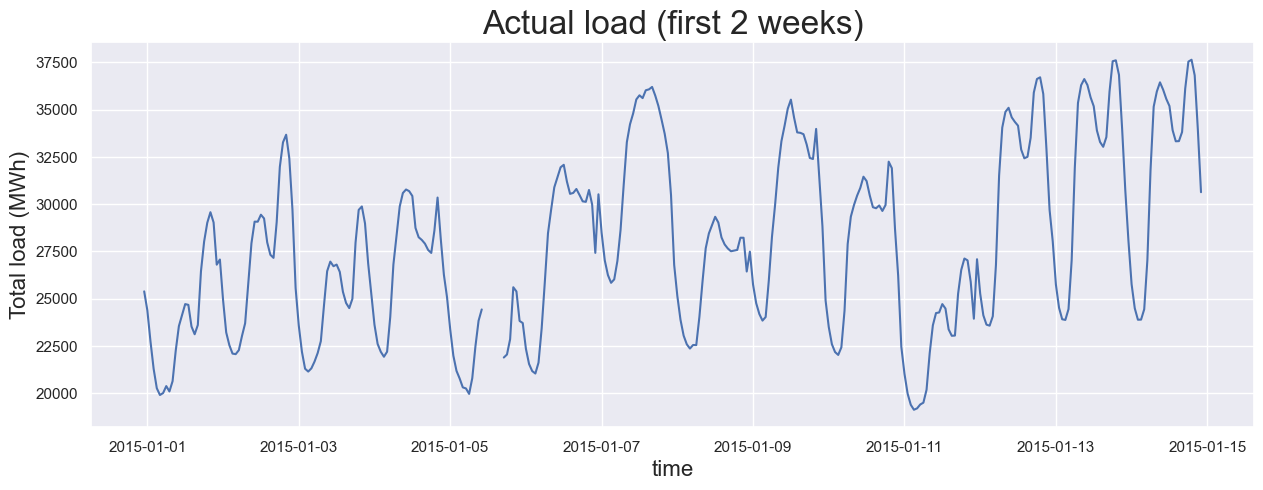

In [11]:
# Plot the actual load
ax = plot_series(df=df_energy,column="total load actual", ylabel="Total load (MWh)",
                 title="Actual load (first 2 weeks)", start=0, end=24*7*2)
plt.show()

Note _missing data_ that would have to be filled with _interpolation_  
Consider if null values are present for other columns as well  

In [12]:
# Display the rows with null values
df_energy[df_energy.isnull().any(axis=1)].tail()

generation biomass  \
time                                            
2016-11-23 03:00:00+00:00                 NaN   
2017-11-14 11:00:00+00:00                 0.0   
2017-11-14 18:00:00+00:00                 0.0   
2018-06-11 16:00:00+00:00               331.0   
2018-07-11 07:00:00+00:00                 NaN   

                           generation fossil brown coal/lignite  \
time                                                              
2016-11-23 03:00:00+00:00                                 900.0   
2017-11-14 11:00:00+00:00                                   0.0   
2017-11-14 18:00:00+00:00                                   0.0   
2018-06-11 16:00:00+00:00                                 506.0   
2018-07-11 07:00:00+00:00                                   NaN   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2016-11-23 03:00:00+00:00                 4838.0                       4547.0   
2017-11-14 11:00:00+00:00                10064.0                          0.0   
2017-11-14 18:00:00+00:00                12336.0                          0.0   
2018-06-11 16:00:00+00:00                 7538.0                       5360.0   
2018-07-11 07:00:00+00:00                    NaN                          NaN   

                           generation fossil oil  \
time                                               
2016-11-23 03:00:00+00:00                  269.0   
2017-11-14 11:00:00+00:00                    0.0   
2017-11-14 18:00:00+00:00                    0.0   
2018-06-11 16:00:00+00:00                  300.0   
2018-07-11 07:00:00+00:00                    NaN   

                           generation hydro pumped storage consumption  \
time                                                                     
2016-11-23 03:00:00+00:00                                       1413.0   
2017-11-14 11:00:00+00:00                                          0.0   
2017-11-14 18:00:00+00:00                                          0.0   
2018-06-11 16:00:00+00:00                                          1.0   
2018-07-11 07:00:00+00:00                                          NaN   

                           generation hydro run-of-river and poundage  \
time                                                                    
2016-11-23 03:00:00+00:00                                       795.0   
2017-11-14 11:00:00+00:00                                         0.0   
2017-11-14 18:00:00+00:00                                         0.0   
2018-06-11 16:00:00+00:00                                      1134.0   
2018-07-11 07:00:00+00:00                                         NaN   

                           generation hydro water reservoir  \
time                                                          
2016-11-23 03:00:00+00:00                             435.0   
2017-11-14 11:00:00+00:00                               0.0   
2017-11-14 18:00:00+00:00                               0.0   
2018-06-11 16:00:00+00:00                            4258.0   
2018-07-11 07:00:00+00:00                               NaN   

                           generation nuclear  generation other  \
time                                                              
2016-11-23 03:00:00+00:00              5040.0              60.0   
2017-11-14 11:00:00+00:00                 0.0               0.0   
2017-11-14 18:00:00+00:00                 0.0               0.0   
2018-06-11 16:00:00+00:00              5856.0              52.0   
2018-07-11 07:00:00+00:00                 NaN               NaN   

                           generation other renewable  generation solar  \
time                                                                      
2016-11-23 03:00:00+00:00                        85.0              15.0   
2017-11-14 11:00:00+00:00                         0.0               0.0   
2017-11-14 18:00:00+00:00            

Following examination will confirm that nans exist in all columns for the same time window.  
Employ linear interpolation for missing values

In [13]:
# Display the number of non-zero values in each column
print("non-zero values in each column\n", 
      df_energy.astype(bool).sum(axis=0),sep="\n")

non-zero values in each column

generation biomass                             35060
generation fossil brown coal/lignite           24547
generation fossil gas                          35063
generation fossil hard coal                    35061
generation fossil oil                          35061
generation hydro pumped storage consumption    22457
generation hydro run-of-river and poundage     35061
generation hydro water reservoir               35061
generation nuclear                             35061
generation other                               35060
generation other renewable                     35061
generation solar                               35061
generation waste                               35061
generation wind onshore                        35061
total load actual                              35064
price day ahead                                35064
price actual                                   35064
dtype: int64


Large number of zeros in `generation hydro pumped storage consumption` is because this energy generation is used only at peap production

> Dataset is cleaned

In [14]:
df_energy.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

# Weather features dataset

In [15]:
df_weather.head()

dt_iso city_name     temp  temp_min  temp_max  pressure  \
0  2015-01-01 00:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
1  2015-01-01 01:00:00+01:00  Valencia  270.475   270.475   270.475      1001   
2  2015-01-01 02:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
3  2015-01-01 03:00:00+01:00  Valencia  269.686   269.686   269.686      1002   
4  2015-01-01 04:00:00+01:00  Valencia  269.686   269.686   269.686      1002   

   humidity  wind_speed  wind_deg  rain_1h  rain_3h  snow_3h  clouds_all  \
0        77           1        62      0.0      0.0      0.0           0   
1        77           1        62      0.0      0.0      0.0           0   
2        78           0        23      0.0      0.0      0.0           0   
3        78           0        23      0.0      0.0      0.0           0   
4        78           0        23      0.0      0.0      0.0           0   

   weather_id weather_main weather_description weather_icon  
0         800        clear        sky is clear          01n  
1         800        clear        sky is clear          01n  
2         800        clear        sky is clear          01n  
3         800        clear        sky is clear          01n  
4         800        clear        sky is clear          01n

In [16]:
df_weather.describe().round(2)

temp   temp_min   temp_max    pressure   humidity  wind_speed  \
count  178396.00  178396.00  178396.00   178396.00  178396.00   178396.00   
mean      289.62     288.33     291.09     1069.26      68.42        2.47   
std         8.03       7.96       8.61     5969.63      21.90        2.10   
min       262.24     262.24     262.24        0.00       0.00        0.00   
25%       283.67     282.48     284.65     1013.00      53.00        1.00   
50%       289.15     288.15     290.15     1018.00      72.00        2.00   
75%       295.15     293.73     297.15     1022.00      87.00        4.00   
max       315.60     315.15     321.15  1008371.00     100.00      133.00   

        wind_deg    rain_1h    rain_3h    snow_3h  clouds_all  weather_id  
count  178396.00  178396.00  178396.00  178396.00   178396.00   178396.00  
mean      166.59       0.08       0.00       0.00       25.07      759.83  
std       116.61       0.40       0.01       0.22       30.77      108.73  
min         0.00       0.00       0.00       0.00        0.00      200.00  
25%        55.00       0.00       0.00       0.00        0.00      800.00  
50%       177.00       0.00       0.00       0.00       20.00      800.00  
75%       270.00       0.00       0.00       0.00       40.00      801.00  
max       360.00      12.00       2.32      21.50      100.00      804.00

Same number of rows in each column. 
- Check if this holds true for each city. 

Note:
- Temperature is in kelvin
- Pressure has outliers (it can be so large)
- Wind has outliers
- "rain_1h" must be < "rain_3h" however, this is not the case. 

In [17]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt_iso               178396 non-null  object 
 1   city_name            178396 non-null  object 
 2   temp                 178396 non-null  float64
 3   temp_min             178396 non-null  float64
 4   temp_max             178396 non-null  float64
 5   pressure             178396 non-null  int64  
 6   humidity             178396 non-null  int64  
 7   wind_speed           178396 non-null  int64  
 8   wind_deg             178396 non-null  int64  
 9   rain_1h              178396 non-null  float64
 10  rain_3h              178396 non-null  float64
 11  snow_3h              178396 non-null  float64
 12  clouds_all           178396 non-null  int64  
 13  weather_id           178396 non-null  int64  
 14  weather_main         178396 non-null  object 
 15  weather_descripti

In [18]:
# Convert columns with int64 type values to float64 type
def df_convert_dtypes(df : pd.DataFrame, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df
df_weather = df_convert_dtypes(df_weather,np.int64, np.float64)

In [19]:
# Display average weather features grouped by each city
df_weather['time'] = pd.to_datetime(df_weather['dt_iso'], utc=True, infer_datetime_format=True)
df_weather = df_weather.drop(['dt_iso'], axis=1)
df_weather = df_weather.set_index('time')

In [20]:
# Display average weather features grouped by each city
mean_weather_by_city = df_weather.groupby("city_name").mean()
mean_weather_by_city

temp    temp_min    temp_max     pressure   humidity  \
city_name                                                                
 Barcelona  289.848248  288.594704  291.021987  1284.010486  73.994221   
Bilbao      286.378489  284.916661  288.036687  1017.567439  79.089455   
Madrid      288.061071  286.824877  289.155600  1011.838448  59.776932   
Seville     293.105431  291.184103  295.962431  1018.504711  64.140732   
Valencia    290.780780  290.222277  291.355025  1015.973794  65.145113   

            wind_speed    wind_deg   rain_1h   rain_3h   snow_3h  clouds_all  \
city_name                                                                      
 Barcelona    2.786588  187.188043  0.117079  0.000327  0.000000   23.229648   
Bilbao        1.957470  159.883536  0.123493  0.001034  0.023455   43.960697   
Madrid        2.441696  173.293159  0.055083  0.000129  0.000029   22.397028   
Seville       2.483787  151.757179  0.045392  0.000180  0.000000   14.748770   
Valencia      2.692815  160.753820  0.035924  0.000226  0.000154   20.820999   

            weather_id  
city_name               
 Barcelona  760.917465  
Bilbao      723.943228  
Madrid      762.260264  
Seville     771.409849  
Valencia    781.228283

In [21]:
# Find nans and duplicates in weather

nans = df_weather.isnull().values.sum()
print(f"Nans={nans}")

dups = df_weather.duplicated(keep="first").sum()
print(f"dups={dups}")

cities = df_weather["city_name"].unique()
grouped_weather = df_weather.groupby("city_name")

for city in cities:
    datas = grouped_weather.get_group(city).shape[0]
    print(f"City={city} has {datas} data")

Nans=0
dups=8622
City=Valencia has 35145 data
City=Madrid has 36267 data
City=Bilbao has 35951 data
City= Barcelona has 35476 data
City=Seville has 35557 data


Data is not the same for each city.   
Duplicates present.  

Needs cleaning.  

In [22]:
# Create df_weather_2 and drop duplicate rows in df_weather

df_weather_2 = df_weather.reset_index().drop_duplicates(
    subset=["time","city_name"], keep="last"
).set_index("time")

df_weather = df_weather.reset_index().drop_duplicates(
    subset=["time","city_name"], keep="first"
).set_index("time")

In [23]:
# Display the number of rows in each dataframe again
print(f"df_energy rows = {df_energy.shape[0]}")
grouped_weather = df_weather.groupby("city_name")
for city in cities:
    n = grouped_weather.get_group(city).shape[0]
    print(f"For city {city} there are {n} rows")
print(df_weather.head())

df_energy rows = 35064
For city Valencia there are 35064 rows
For city Madrid there are 35064 rows
For city Bilbao there are 35064 rows
For city  Barcelona there are 35064 rows
For city Seville there are 35064 rows
                          city_name     temp  temp_min  temp_max  pressure  \
time                                                                         
2014-12-31 23:00:00+00:00  Valencia  270.475   270.475   270.475    1001.0   
2015-01-01 00:00:00+00:00  Valencia  270.475   270.475   270.475    1001.0   
2015-01-01 01:00:00+00:00  Valencia  269.686   269.686   269.686    1002.0   
2015-01-01 02:00:00+00:00  Valencia  269.686   269.686   269.686    1002.0   
2015-01-01 03:00:00+00:00  Valencia  269.686   269.686   269.686    1002.0   

                           humidity  wind_speed  wind_deg  rain_1h  rain_3h  \
time                                                                          
2014-12-31 23:00:00+00:00      77.0         1.0      62.0      0.0      0.0   
2

There is some redundant information in df_weather.  
We need to remove it, but check for consistency first.  

In [24]:
# Display all the unique values in the column 'weather_description'
weather_description_unique = df_weather['weather_description'].unique()
weather_description_unique

array(['sky is clear', 'few clouds', 'scattered clouds', 'broken clouds',
       'overcast clouds', 'light rain', 'moderate rain',
       'heavy intensity rain', 'mist', 'heavy intensity shower rain',
       'shower rain', 'very heavy rain', 'thunderstorm with heavy rain',
       'thunderstorm with light rain', 'proximity thunderstorm',
       'thunderstorm', 'light intensity shower rain',
       'light intensity drizzle', 'thunderstorm with rain', 'fog',
       'smoke', 'drizzle', 'heavy intensity drizzle', 'haze',
       'proximity shower rain', 'light snow', 'rain and snow',
       'light rain and snow', 'snow', 'sleet', 'rain and drizzle',
       'light intensity drizzle rain', 'light shower snow',
       'proximity moderate rain', 'ragged shower rain', 'heavy snow',
       'sand dust whirls', 'proximity drizzle', 'dust',
       'light thunderstorm', 'squalls'], dtype=object)

In [25]:
weather_main_unique = df_weather['weather_main'].unique()
weather_main_unique

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [26]:
weather_id_unique = df_weather['weather_id'].unique()
weather_id_unique

array([800., 801., 802., 803., 804., 500., 501., 502., 701., 522., 521.,
       503., 202., 200., 211., 520., 300., 201., 741., 711., 301., 302.,
       721., 600., 616., 615., 601., 611., 311., 310., 620., 531., 602.,
       731., 761., 210., 771.])

Most information (unique values) is in columns `descritption` and `id`. So we need to pick one of those.  

Check for consistency of the information in each column because there are _duplicate rows_ and we chose one of them.  

Compare the two options with R2 statistic. 

In [27]:
def encode_and_display_r2_score(df_1,df_2, column, categorical=False):
    dfs = [df_1,df_2]
    if categorical:
        for df in dfs:
            le = LabelEncoder()
            df[column] = le.fit_transform(df[column])
    r2 = r2_score(df_1[column], df_2[column])
    print(f"R2 of {column} is {r2.round(3)}")

In [28]:
# Display the R-squared scores for the columns with qualitative weather descriptions in df_weather and df_weather_2

encode_and_display_r2_score(df_weather, df_weather_2, 'weather_description', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_main', categorical=True)
encode_and_display_r2_score(df_weather, df_weather_2, 'weather_id')

R2 of weather_description is 0.973
R2 of weather_main is 0.963
R2 of weather_id is 0.921


Result shows inconsistencies in data.  
Qualitative columns contain duplicate information of the weather.  
We need only one.  
$R^2$ shows that it is best to use one-hot encoded `description` or `main`. (The similarity in R2 is due to encoding. Proper encoding requires _Levenshtein distance_). 

In [29]:
# Drop columns with qualitative weather information
df_weather = df_weather.drop(['weather_main', 'weather_id', 
                              'weather_description', 'weather_icon'], axis=1)

In [30]:
# Display the R-squared for all the columns in df_weather and df_weather_2

df_weather_cols = df_weather.columns.drop('city_name')

for col in df_weather_cols:
    encode_and_display_r2_score(df_weather, df_weather_2, col)

R2 of temp is 1.0
R2 of temp_min is 1.0
R2 of temp_max is 1.0
R2 of pressure is 1.0
R2 of humidity is 1.0
R2 of wind_speed is 1.0
R2 of wind_deg is 1.0
R2 of rain_1h is 1.0
R2 of rain_3h is 1.0
R2 of snow_3h is 1.0
R2 of clouds_all is 1.0


In [31]:
# Display the number of duplicates in df_weather

temp_weather = df_weather.reset_index().duplicated(subset=['time', 'city_name'], 
                                                   keep='first').sum()
print('There are {} duplicate rows in df_weather ' \
      'based on all columns except "time" and "city_name".'.format(temp_weather))

There are 0 duplicate rows in df_weather based on all columns except "time" and "city_name".


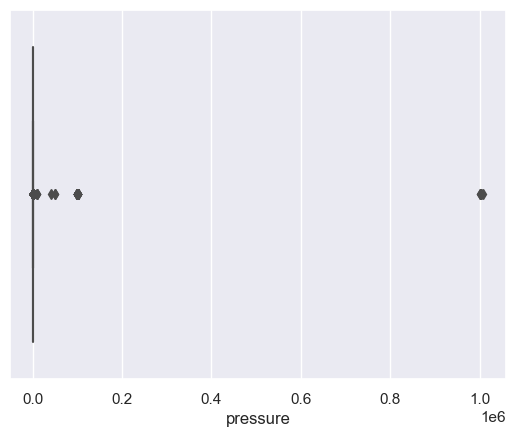

In [32]:
# check for outliers
sns.boxplot(x=df_weather["pressure"])
plt.show()

Now, there are __no__ duplicates and the number of rows for each city is the same as number of rows in _dfenergy_.  

Last step:  
Fixing outliers

Extreme pressures are obviously a mistake.  
We set as nan all values that $>1051$ hPa, which is the highest recorded pressure;  
Same for lower bound. 

In [33]:
df_weather.loc[df_weather.pressure > 1051, "pressure"] = np.nan
df_weather.loc[df_weather.pressure < 931, "pressure"] = np.nan

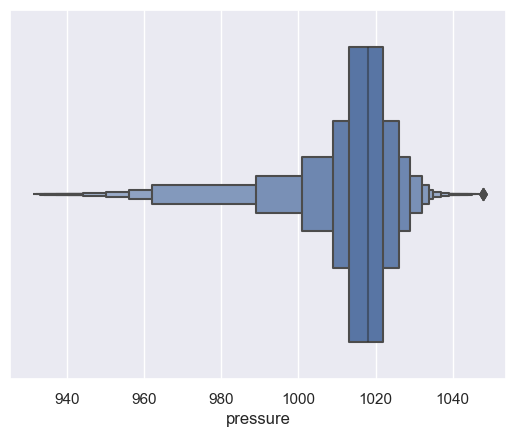

In [34]:
sns.boxenplot(x=df_weather.pressure)
plt.show()

In [35]:
# replace outliers in wind speed
df_weather.loc[df_weather.wind_speed > 50, "wind_speed"] = np.nan

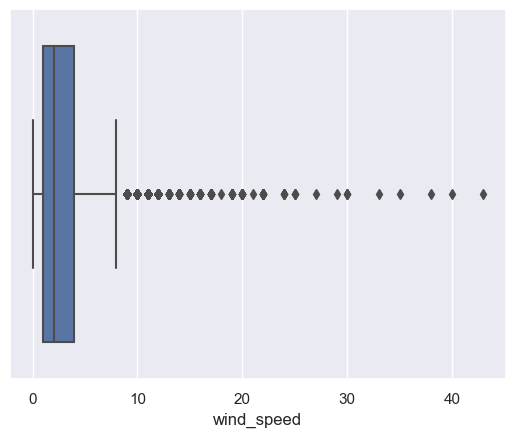

In [36]:
sns.boxplot(x=df_weather.wind_speed)
plt.show()

In [37]:
# Fill nans with interpolation now
df_weather.interpolate(method="linear",
                       limit_direction="forward",
                       inplace=True,
                       axis=0)

# Merging datasets

In [38]:
df_1, df_2, df_3, df_4, df_5 = [x for _, x in df_weather.groupby('city_name')]
dfs = [df_1, df_2, df_3, df_4, df_5]

In [39]:
df_final = df_energy

for df in dfs:
    city = df['city_name'].unique()
    city_str = str(city).replace("'", "").replace('[', '').replace(']', '').replace(' ', '')
    df = df.add_suffix('_{}'.format(city_str))
    df_final = df_final.merge(df, on=['time'], how='outer')
    df_final = df_final.drop('city_name_{}'.format(city_str), axis=1)
    
df_final.columns

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore', 'total load actual',
       'price day ahead', 'price actual', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'temp_Bilbao', 'temp_min_Bilbao',
       'temp_max_Bilbao', 'pressure_Bilbao', 'humidity_Bilbao',
       'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
       'rain_3h_Bilbao', 'snow_3h_Bilbao', 'clo

In [40]:
# Display the number of NaNs and duplicates in the final dataframe

print('There are {} missing values or NaNs in df_final.'
      .format(df_final.isnull().values.sum()))

temp_final = df_final.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_final based on all columns.'
      .format(temp_final))

There are 0 missing values or NaNs in df_final.

There are 0 duplicate rows in df_final based on all columns.


# Visualization

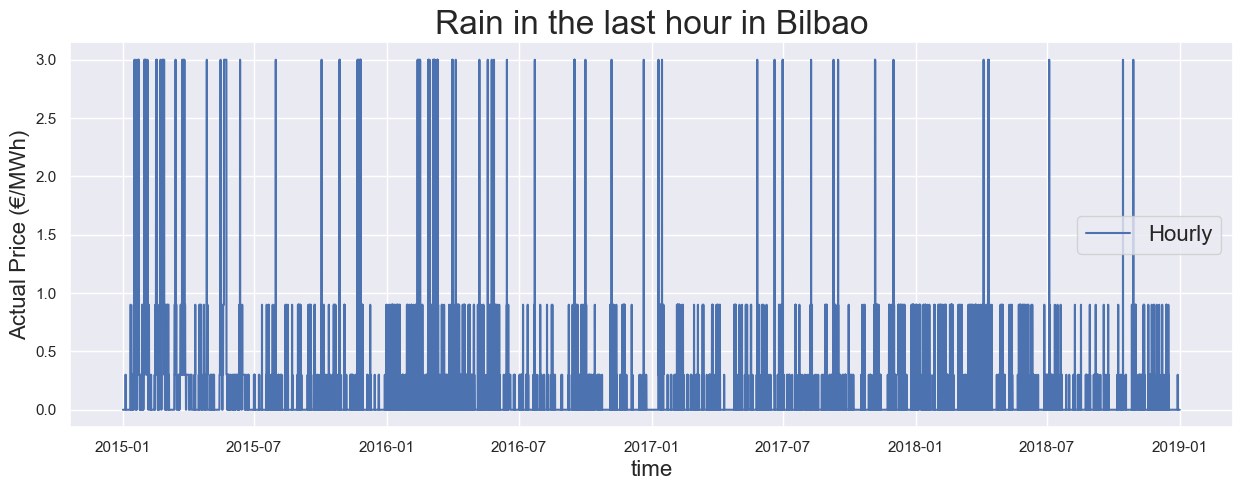

In [41]:
ax = plot_series(df_final, 'rain_1h_Bilbao', 
                 label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Rain in the last hour in Bilbao')
plt.show()

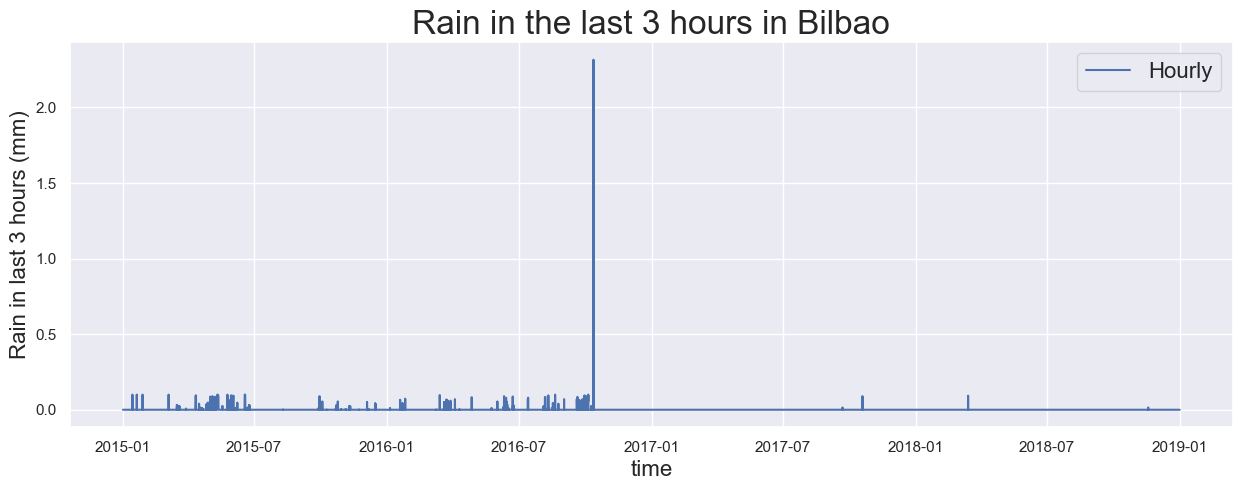

In [42]:
# Plot the 'rain_3h' for Bilbao

ax = plot_series(df_final, 'rain_3h_Bilbao', 
                 label='Hourly', ylabel='Rain in last 3 hours (mm)',
                 title='Rain in the last 3 hours in Bilbao')
plt.show()

#### Observation:  
`rain_3h` is an unreliable feature that is to be dropped

In [43]:
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']

for city in cities:
    df_final = df_final.drop(['rain_3h_{}'.format(city)], axis=1)

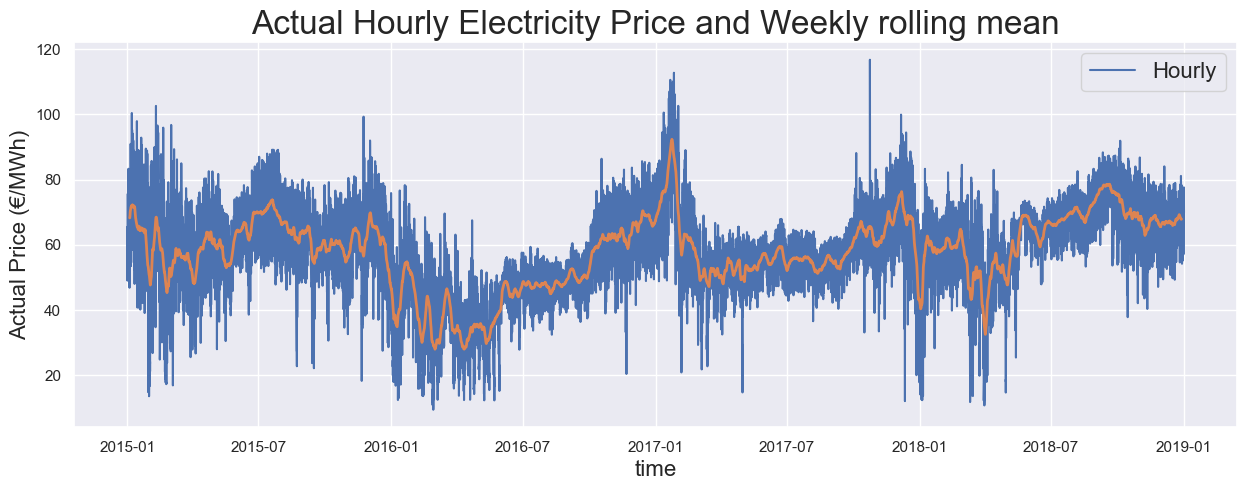

In [44]:
# Plot the hourly actual electricity price, along with the weekly rolling mean

rolling = df_final['price actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

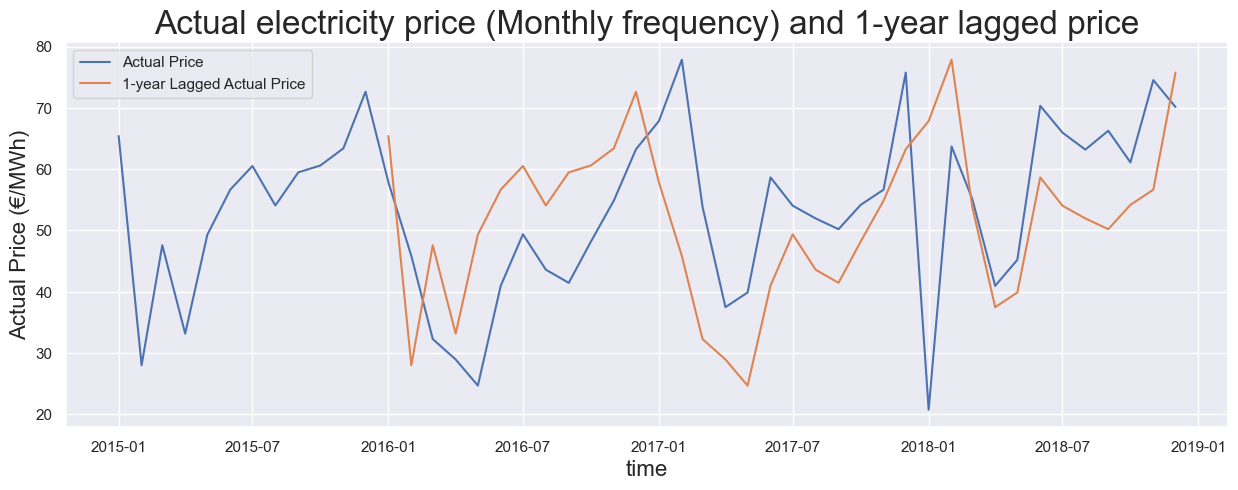

In [45]:
# Plot electricity price (monthly frequence) and 1 year lagged series
monthly_price = df_final["price actual"].asfreq("M")
ax = plot_series(series=monthly_price, ylabel='Actual Price (€/MWh)',
                 title='Actual electricity price (Monthly frequency) and 1-year lagged price')
shifted = df_final["price actual"].asfreq("M").shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Price', '1-year Lagged Actual Price'])
plt.show()


Plot shows seasonal patterns in data at _a monthly scale_, as spikes occure at near the same month.  
- New feature for a month is needed

Lets consider another weekly 

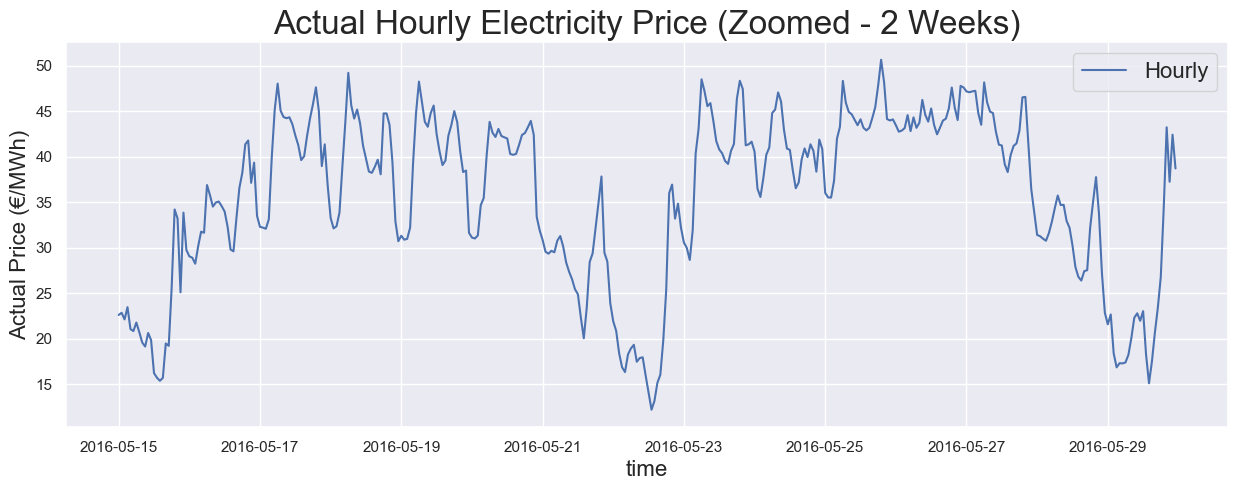

In [46]:
ax = plot_series(df_final, 'price actual', label='Hourly', ylabel='Actual Price (€/MWh)',
                 start=1 + 24 * 500, end=1 + 24 * 515,
                 title='Actual Hourly Electricity Price (Zoomed - 2 Weeks)')
plt.show()

Patterns and periodicities in the data
- Weely pattern
- Intraday periodicity
- Periodicy wuthin business hours (lunch break price drop...) This country does not follow 9-5 hour work day

> Additional features are needed that would allow to capture this information

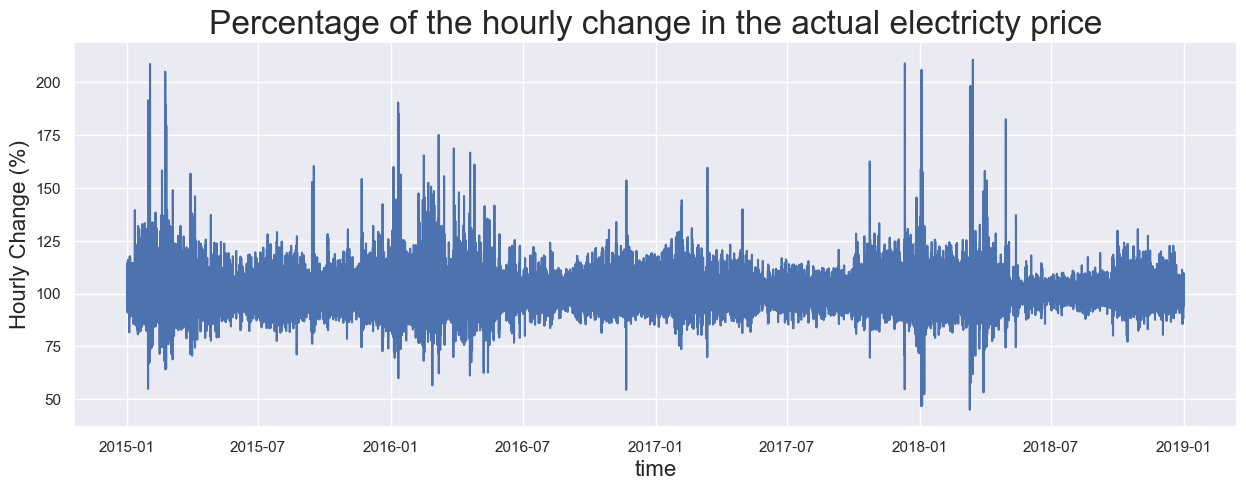

In [47]:
change = df_energy["price actual"].div(df_energy["price actual"].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)', 
                 title='Percentage of the hourly change in the actual electricty price')
plt.show()

Hourly change can reach $100\%$ in a few cases, but overall is within $25\%$

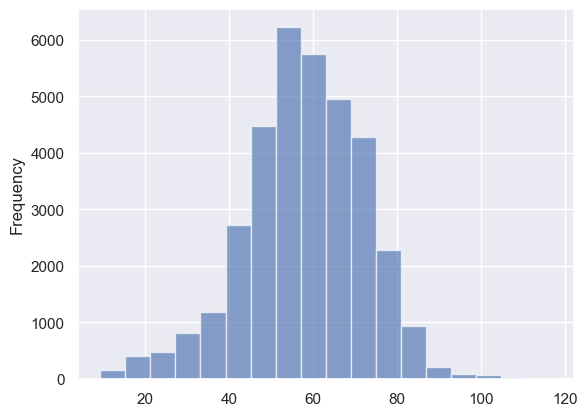

In [48]:
ax = df_energy["price actual"].plot.hist(bins=18,alpha=.65)

The distribution is close to normal, can be standardized.  
Before that, we need to check for stationarity.   

# Stationarity Tests

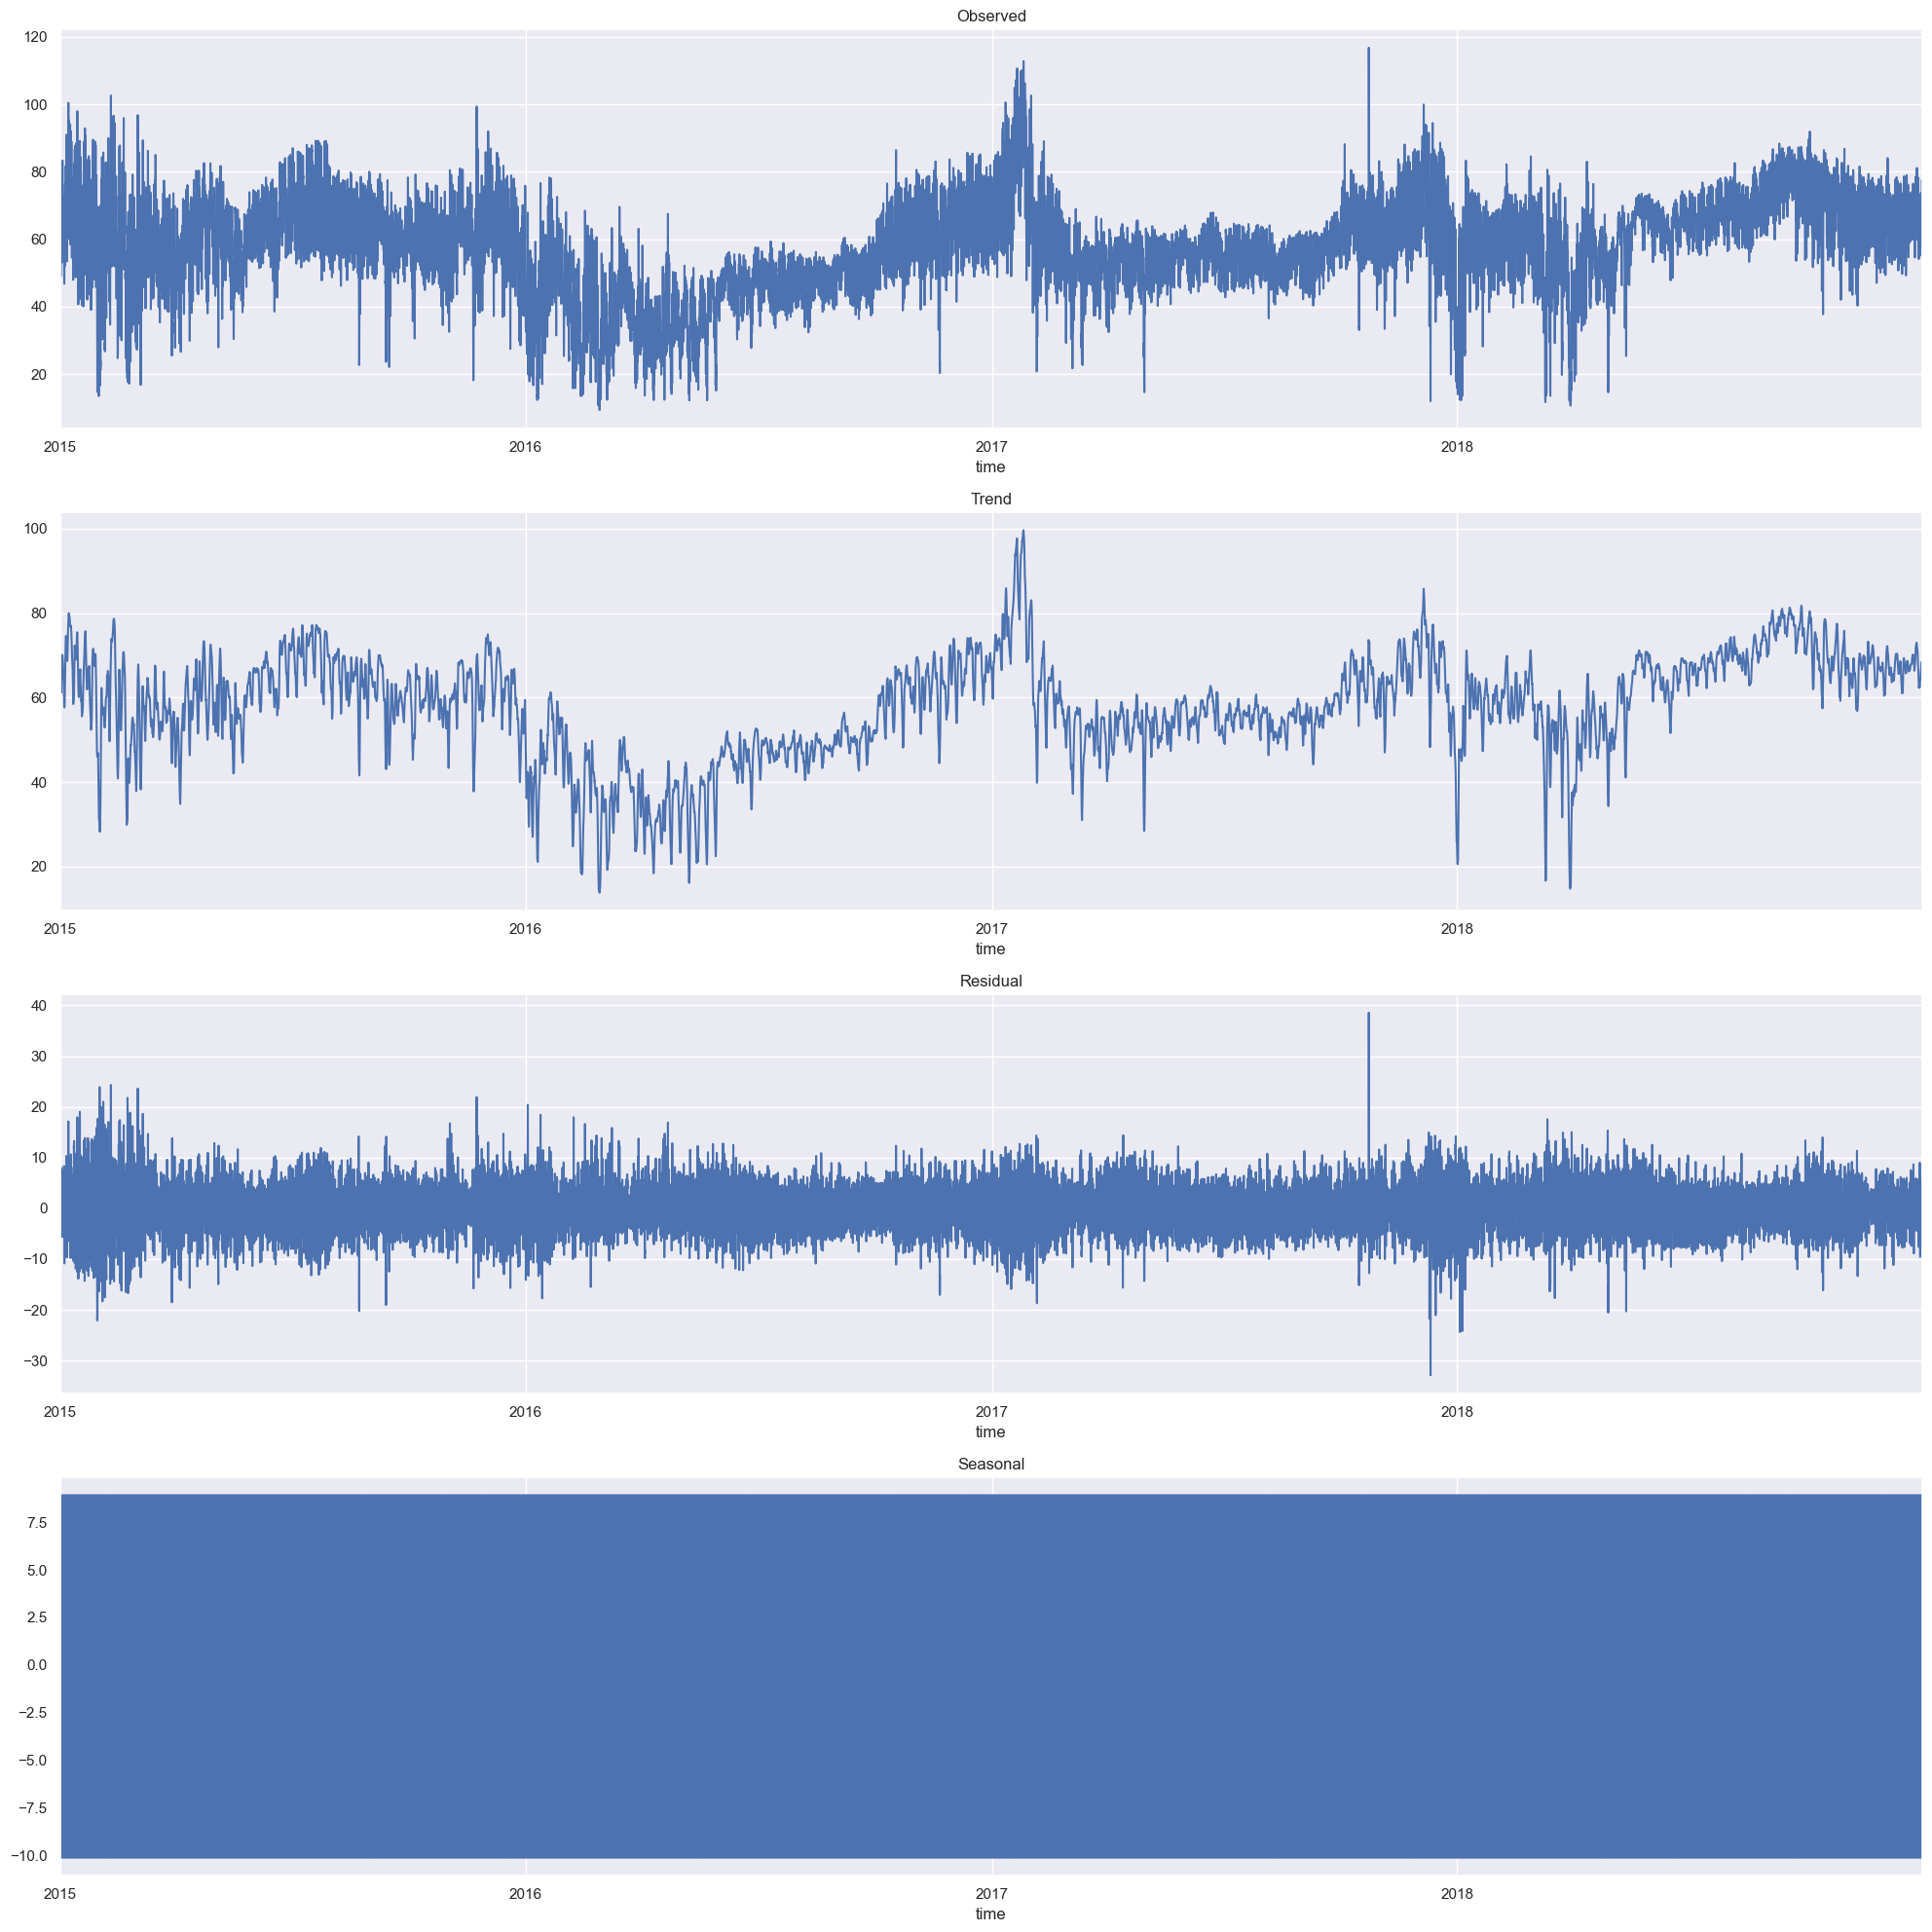

In [49]:
# Decompose the electricity price time series
res = sm.tsa.seasonal_decompose(df_energy["price actual"], model="additive")

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 20))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

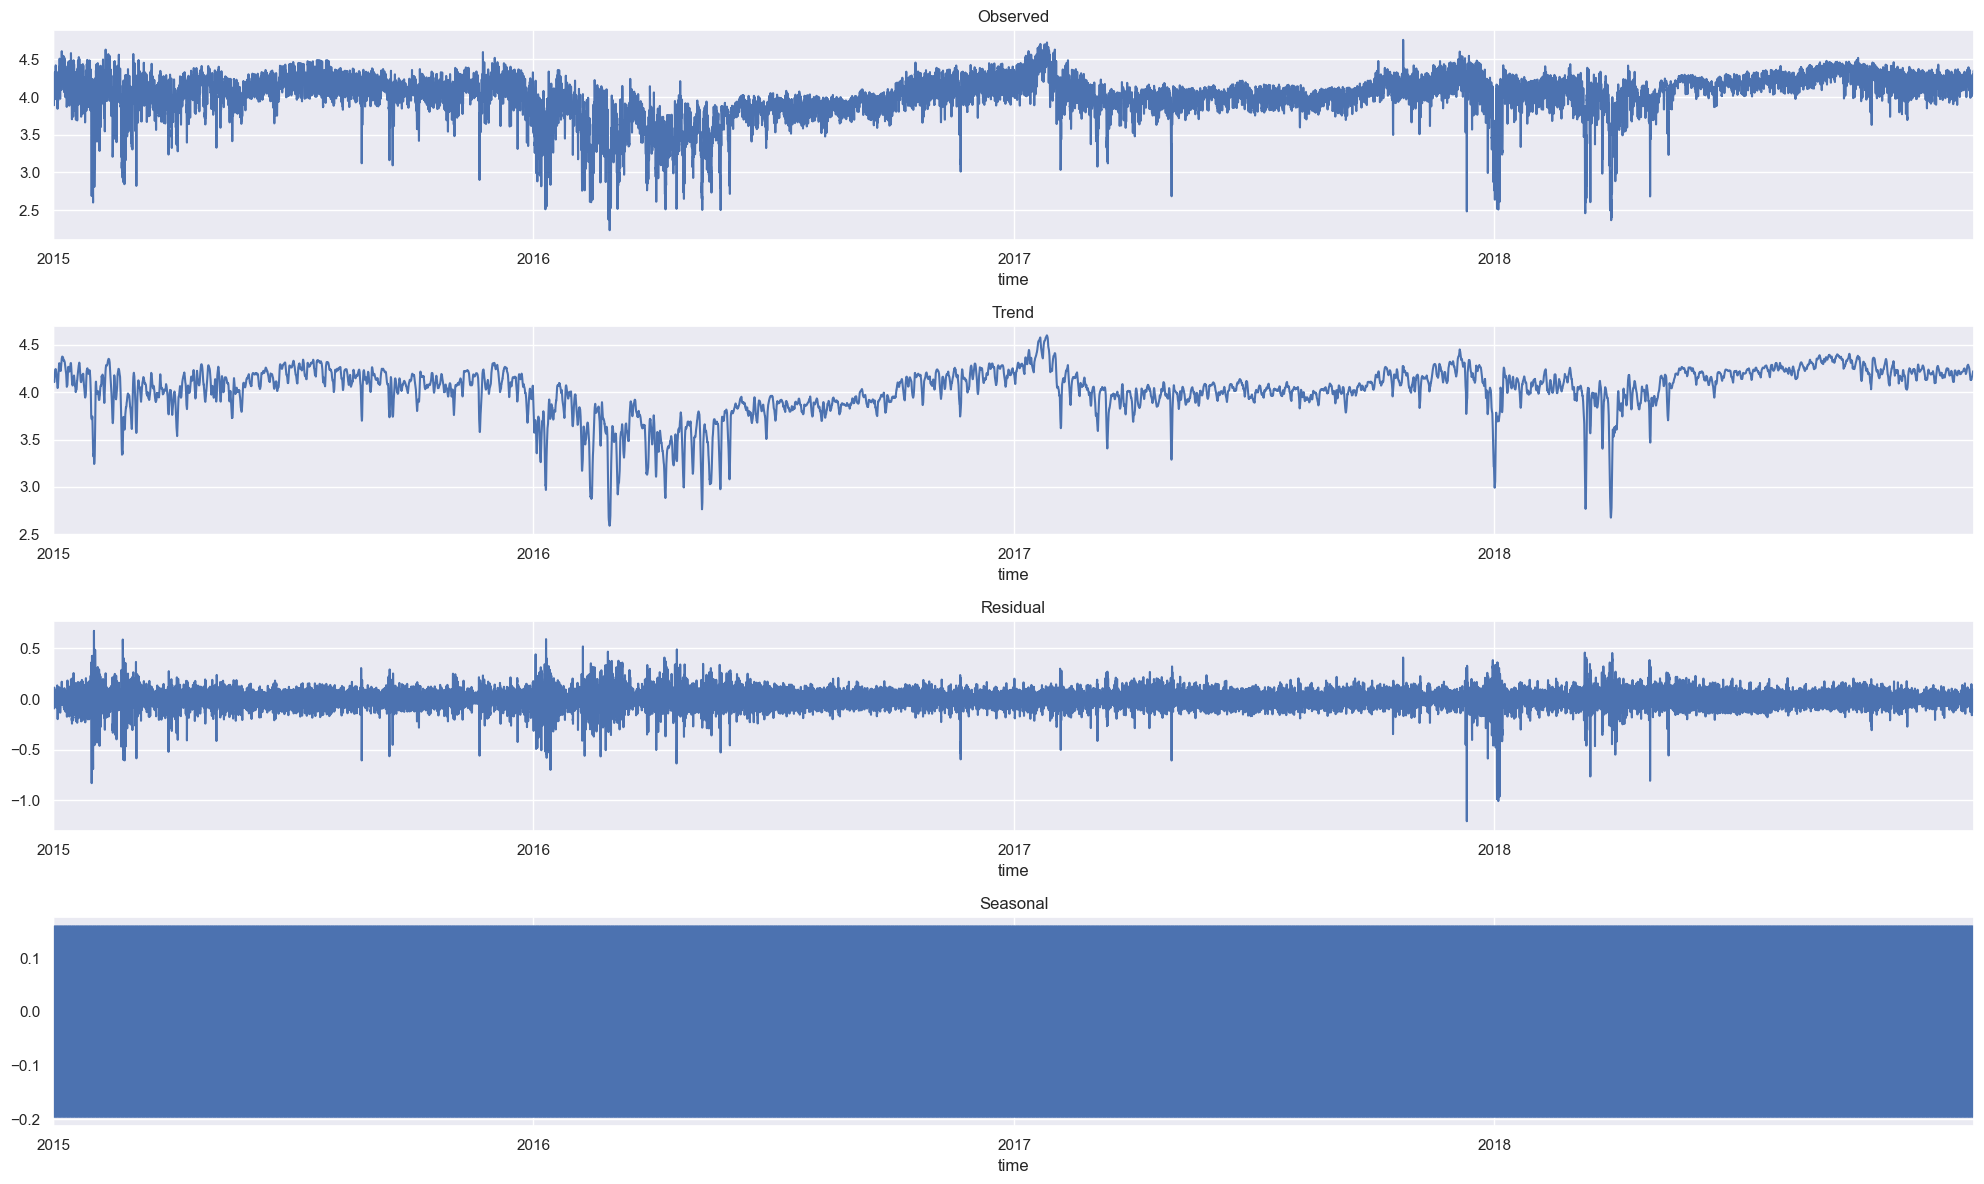

In [50]:
# Decompose the log electricity price time-series

res = sm.tsa.seasonal_decompose(np.log(df_energy['price actual']), model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

The **Augmented Dickey-Fuller (ADF) test**, a type of unit root test, determines how strongly a time series is defined by a trend. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- **Alternate Hypothesis** $H_{1}$: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [51]:
y = df_final['price actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -9.147016
p-value: 0.000000
#Lags used: 50
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


The ADF statistic (-9.147) is less than the critical value at 1% (-3.431) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

The **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**, follows the opposite logic from Augmented Dickey-Fuller test and checks for  stationarity. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: The time series is level, i.e. it is stationary around a constant.
- **Alternate Hypothesis** $H_{1}$: There is a unit root in the time series and thus it not stationary.

In [52]:
kpss_test = kpss(y, regression='c', nlags='legacy')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 7.957007
p-value: 0.010000
#Lags used: 52
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


The KPSS statistic (7.957) is higher than the critical value at 1% (0.739) and thus, we can say that we cannot reject the null hypothesis  𝐻0
  with a significance level 1%, meaning that the time series is stationary or stationary around a constant.

Both tests concluded that the electricity price time series is stationary, while it is also true that deep neural networks can handle such properties in a more forgiving way compared to ARIMA models

# Autocorrelation, partial autocorrelation, cross-correlation

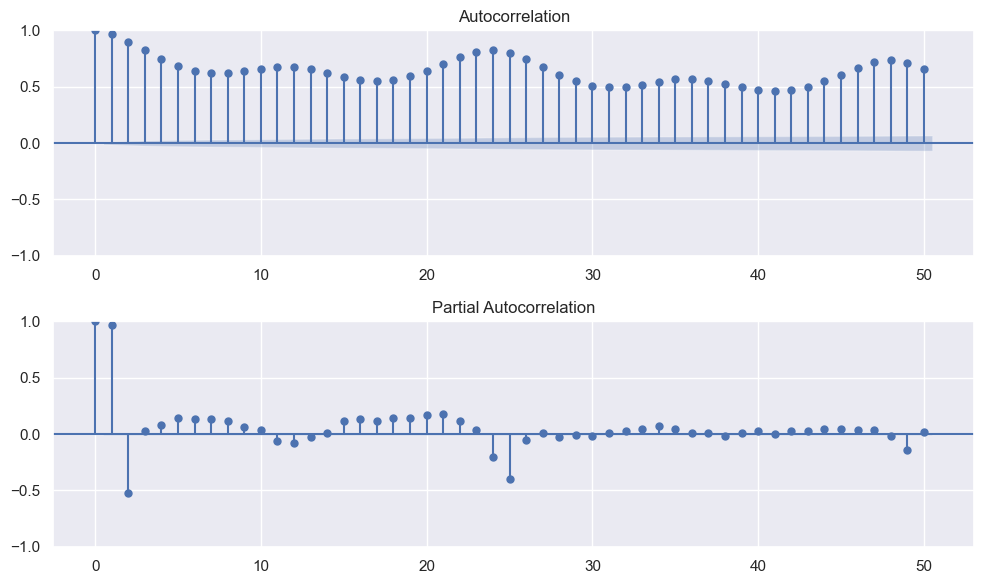

In [53]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_final['price actual'], lags=50, ax=ax1)
plot_pacf(df_final['price actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

`Partial autocorrelation` shows that the relationship exist between $t-1$, $t-2$ and $t-\sim 25$ timesteps and is smaller afterworeds

Other correlation:

[ 0.43525273  0.41794007  0.35530763 ... -0.27230731 -0.39742762
 -0.49135358]


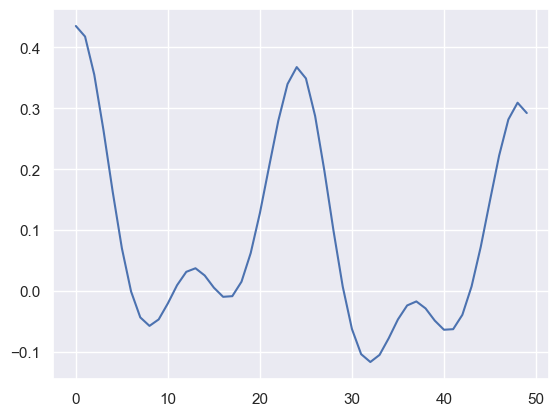

In [54]:
cross_corr = ccf(df_final['total load actual'], df_final['price actual'])
print(cross_corr)
plt.plot(cross_corr[0:50])
plt.show()

In this plot we `should` see that some correlations are close to 0 and these data points can be _explcuded_.  
### Correlations between different features

In [55]:
correlations = df_final.corr(method="pearson")
print(correlations["price actual"].sort_values(ascending=False).to_string())

price actual                                   1.000000
price day ahead                                0.732155
generation fossil hard coal                    0.465637
generation fossil gas                          0.461452
total load actual                              0.435253
generation fossil brown coal/lignite           0.363993
generation fossil oil                          0.285050
generation other renewable                     0.255551
pressure_Barcelona                             0.249177
pressure_Bilbao                                0.194063
generation waste                               0.168710
generation biomass                             0.142671
temp_min_Valencia                              0.133141
pressure_Valencia                              0.109812
temp_min_Barcelona                             0.103726
generation other                               0.099914
generation solar                               0.098529
temp_max_Madrid                                0

In [56]:
# Drop columns with nans 
df_final = df_final.drop(['snow_3h_Barcelona', 'snow_3h_Seville'], axis=1)


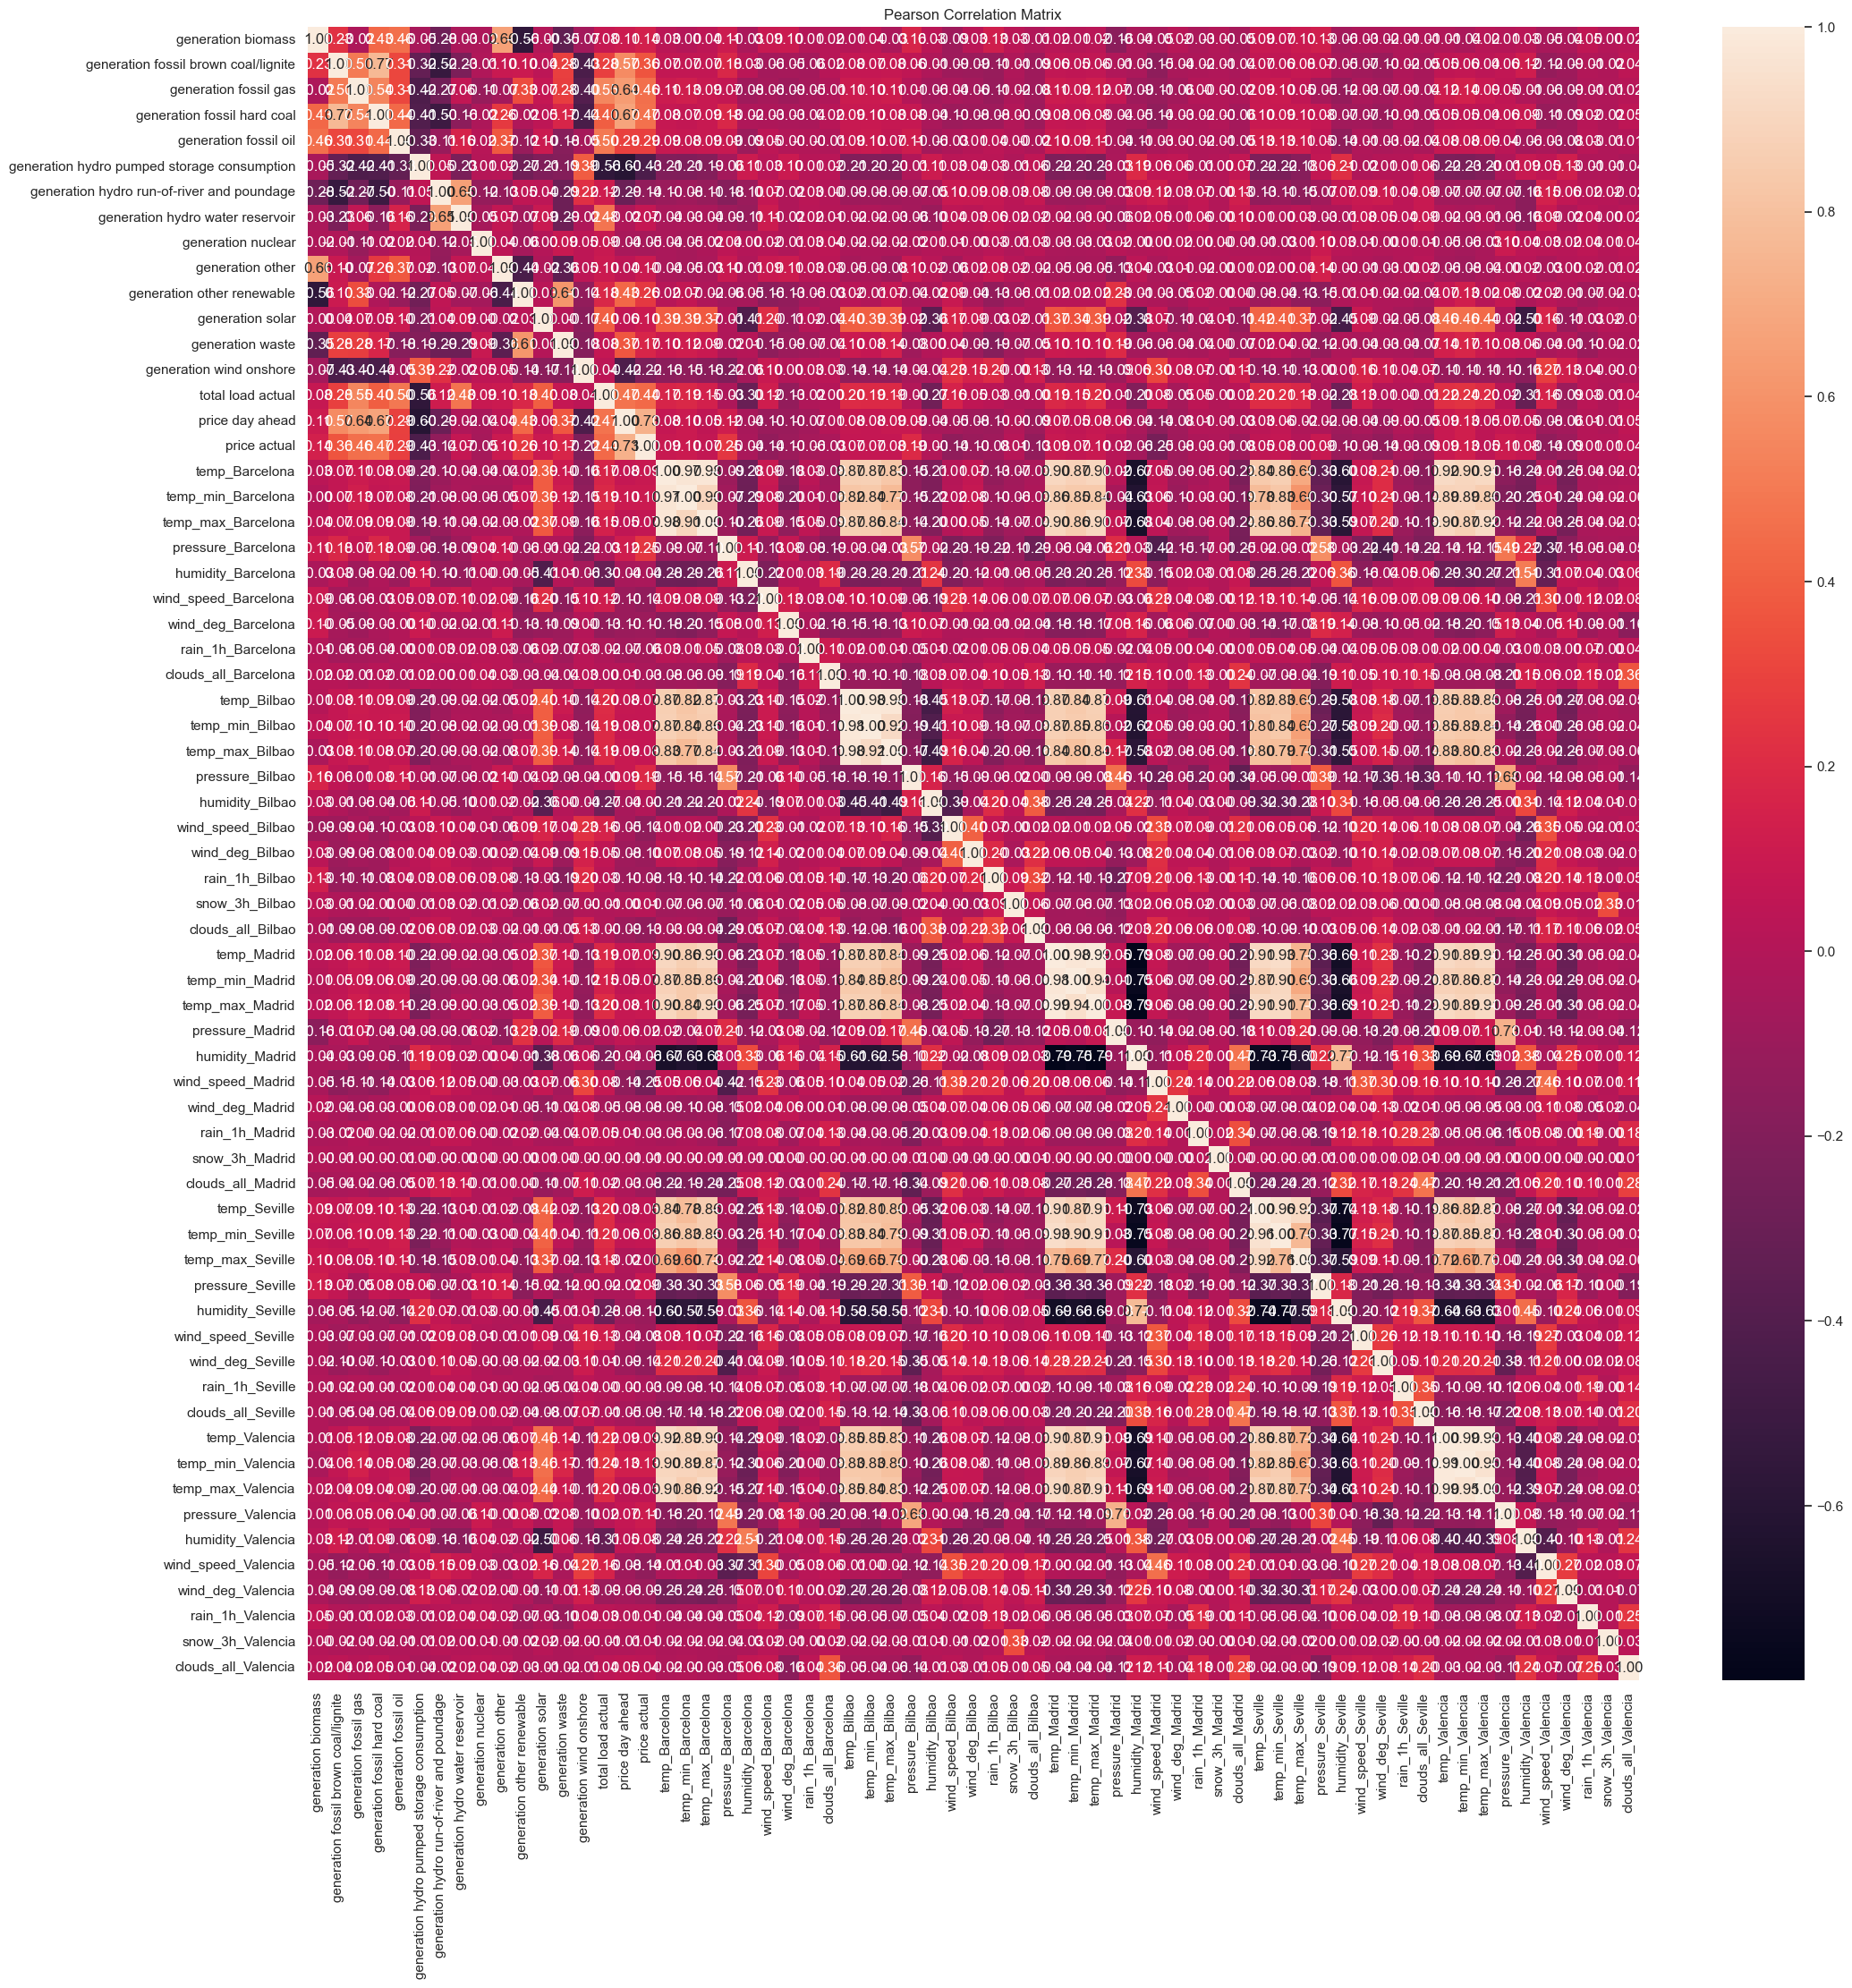

In [57]:
# Plot Pearson correlation matrix
correlations = df_final.corr(method="pearson")
fig = plt.figure(figsize=(24,24))
sns.heatmap(correlations,annot=True,fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.show()

In [58]:
print(df_final.isnull().sum(axis=0))

generation biomass                      0
generation fossil brown coal/lignite    0
generation fossil gas                   0
generation fossil hard coal             0
generation fossil oil                   0
                                       ..
wind_speed_Valencia                     0
wind_deg_Valencia                       0
rain_1h_Valencia                        0
snow_3h_Valencia                        0
clouds_all_Valencia                     0
Length: 65, dtype: int64


Plot shows taht there are a lot of features correlated with each other

In [59]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
temp_Barcelona                        temp_min_Barcelona                      0.970264
                                      temp_max_Barcelona                      0.976904
                                      temp_Bilbao                             0.866727
                                      temp_min_Bilbao                         0.867970
                                      temp_max_Bilbao                         0.828347
                                      temp_Madrid                             0.903996
                                      temp_min_Madrid                         0.874548
                                      temp_max_Madrid                         0.899010
                                      temp_Seville                            0.841910
                                      temp_

Correlations observed:
- Energy generation with other energy generation
- Temeprature in a given city with aother temperatures in other cities


# Feature Engineering
1. Time features

In [60]:
# Generate 'hour', 'weekday' and 'month' features
for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    df_final.loc[position, 'hour'] = hour
    df_final.loc[position, 'weekday'] = weekday
    df_final.loc[position, 'month'] = month

# Generate 'business hour' feature (1-hot encoded)
for i in range(len(df_final)):
    position = df_final.index[i]
    hour = position.hour
    if ((hour > 8 and hour < 14) or (hour > 16 and hour < 21)):
        df_final.loc[position, 'business hour'] = 2
    elif (hour >= 14 and hour <= 16):
        df_final.loc[position, 'business hour'] = 1
    else:
        df_final.loc[position, 'business hour'] = 0

# Encode weekends
for i in range(len(df_final)):
    position = df_final.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        df_final.loc[position, 'weekday'] = 2
    elif (weekday == 5):
        df_final.loc[position, 'weekday'] = 1
    else:
        df_final.loc[position, 'weekday'] = 0

# add temperature range for each city
cities = ['Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia']
for i in range(len(df_final)):
    position = df_final.index[i]
    for city in cities:
        temp_max = df_final.loc[position, 'temp_max_{}'.format(city)]
        temp_min = df_final.loc[position, 'temp_min_{}'.format(city)]
        df_final.loc[position, 'temp_range_{}'.format(city)] = abs(temp_max - temp_min)

# using FOUND correlation between temperatures, we add weighted temperature
# by the population of the city
total_pop = 6155116 + 5179243 + 1645342 + 1305342 + 987000
weight_Madrid = 6155116 / total_pop
weight_Barcelona = 5179243 / total_pop
weight_Valencia = 1645342 / total_pop
weight_Seville = 1305342 / total_pop
weight_Bilbao = 987000 / total_pop
cities_weights = {'Madrid': weight_Madrid, 
                  'Barcelona': weight_Barcelona,
                  'Valencia': weight_Valencia,
                  'Seville': weight_Seville,
                  'Bilbao': weight_Bilbao}
# Generate 'temp_weighted' feature
for i in range(len(df_final)):
    position = df_final.index[i]
    temp_weighted = 0
    for city in cities:
        temp = df_final.loc[position, 'temp_{}'.format(city)]
        temp_weighted += temp * cities_weights.get('{}'.format(city))
    df_final.loc[position, 'temp_weighted'] = temp_weighted

# using OBSERVED correlation in energy generation, we aggregate 
df_final['generation coal all'] = df_final['generation fossil hard coal'] \
                                + df_final['generation fossil brown coal/lignite']


In [61]:
print(df_final.isnull().sum(axis=0))

generation biomass                      0
generation fossil brown coal/lignite    0
generation fossil gas                   0
generation fossil hard coal             0
generation fossil oil                   0
                                       ..
temp_range_Madrid                       0
temp_range_Seville                      0
temp_range_Valencia                     0
temp_weighted                           0
generation coal all                     0
Length: 76, dtype: int64


# Feature Selectron

In [62]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [63]:
train_end_idx = 27048
cv_end_idx = 31056
test_end_idx = 35064

In [64]:
X = df_final[df_final.columns.drop('price actual')].values
y = df_final['price actual'].values

y = y.reshape(-1, 1)



In [65]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [66]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [67]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)
print(X_norm[np.isnan(X_norm)])

[]


In [68]:
pca = PCA()
X_pca = pca.fit(X_norm[:train_end_idx])

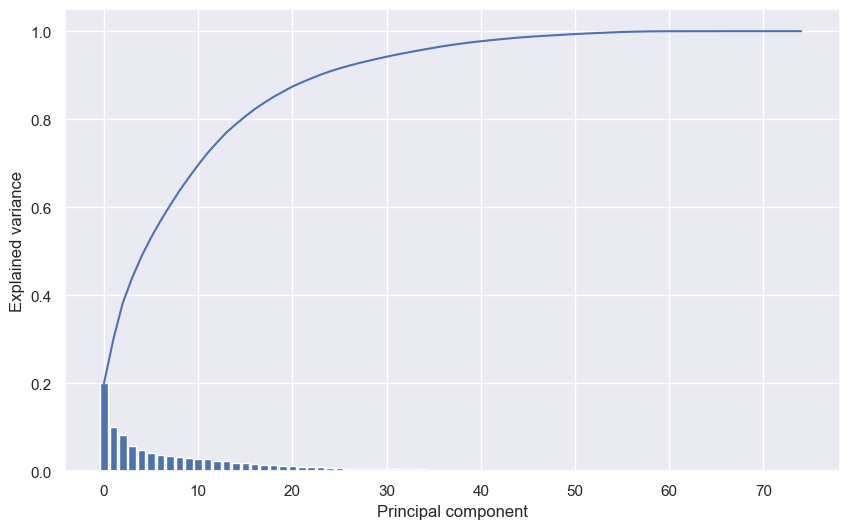

In [69]:
num_components = len(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal component')
plt.ylabel('Explained variance')
plt.show()

In [70]:
pca = PCA(n_components=0.80)
pca.fit(X_norm[:train_end_idx])
X_pca = pca.transform(X_norm)

In [71]:
X_pca.shape

(35064, 16)

In [72]:
dataset_norm = np.concatenate((X_pca, y_norm), axis=1)

past_history = 24
future_target = 0

In [73]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)
X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)
X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [74]:
batch_size = 32
buffer_size = 1000

In [75]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

2023-10-10 16:37:21.450608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 16:37:21.451479: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [76]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [77]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

In [ ]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

# XGBoost

In [78]:
X_train_xgb = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_val_xgb = X_val.reshape(-1, X_val.shape[1] * X_val.shape[2])
X_test_xgb = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

param = {'eta': 0.03, 'max_depth': 180, 
         'subsample': 1.0, 'colsample_bytree': 0.95, 
         'alpha': 0.1, 'lambda': 0.15, 'gamma': 0.1,
         'objective': 'reg:linear', 'eval_metric': 'rmse', 
         'silent': 1, 'min_child_weight': 0.1, 'n_jobs': -1}

dtrain = xgb.DMatrix(X_train_xgb, y_train)
dval = xgb.DMatrix(X_val_xgb, y_val)
dtest = xgb.DMatrix(X_test_xgb, y_test)
eval_list = [(dtrain, 'train'), 
             (dval, 'eval')]

xgb_model = xgb.train(param, dtrain, 180, eval_list, early_stopping_rounds=3)

forecast = xgb_model.predict(dtest)
xgb_forecast = forecast.reshape(-1, 1)

xgb_forecast_inv = scaler_y.inverse_transform(xgb_forecast)

rmse_xgb = sqrt(mean_squared_error(y_test_inv, xgb_forecast_inv))
print('RMSE of hour-ahead electricity price XGBoost forecast: {}'
      .format(round(rmse_xgb, 3)))

[16:40:01] WARNING: /croot/xgboost-split_1675457761144/work/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[16:40:01] WARNING: /croot/xgboost-split_1675457761144/work/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-rmse:0.14413	eval-rmse:0.11700
[1]	train-rmse:0.14021	eval-rmse:0.11393
[2]	train-rmse:0.13622	eval-rmse:0.11073
[3]	train-rmse:0.13236	eval-rmse:0.10761
[4]	train-rmse:0.12862	eval-rmse:0.10462
[5]	train-rmse:0.12499	eval-rmse:0.10171
[6]	train-rmse:0.12148	eval-rmse:0.09887
[7]	train-rmse:0.11808	eval-rmse:0.09611
[8]	train-rmse:0.11480	eval-rmse:0.09346
[9]	train-rmse:0.11160	eval-rmse:0.09092
[10]	train-rmse:0.10852	eval-rmse:0.08845
[11]	train-rmse:0.10568	eval-rmse:0.08622
[12]	train-rmse:0.10294	eval-rmse:0.08410
[13]	train-rmse:0.10012	eval-rmse:0.08184
[14]	train-rmse:0.09740	eval-rmse:0.07965
[15]	train-rmse:0.09476	eval-rmse:0.07754
[16]	train-rmse:0.09221	eval-rmse:0.07548
[17]	train-rmse:0.0

# LSTM

In [ ]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, rangeeturn_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), 
                   save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

plot_model_rmse_and_loss(history)

multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of hour-ahead electricity price LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))